Simple demand response system using machine learning to predict electricity load and respond accordingly. This example uses the Electricity Load Diagrams Dataset from the UCI Machine Learning Repository.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Renewable_Energy/Demand_Response_SmartGrids

/content/drive/MyDrive/Renewable_Energy/Demand_Response_SmartGrids


# Demand Response in Smart Grids

Objective:

Develop a demand response system that automatically adjusts the load based on grid conditions.

-----------------------------------------------------------

Dataset:

The Electricity Load Diagrams Dataset, available from the UCI Machine Learning Repository.

-----------------------------------------------------------

Python Libraries:

pandas - Pandas

numpy - NumPy

matplotlib.pyplot - Matplotlib

sklearn.model_selection and sklearn.preprocessing - Scikit-learn

sklearn.linear_model.LinearRegression - Scikit-learn

sklearn.metrics - Scikit-learn

zipfile - (No additional library required, part of Python's standard library)

seaborn - Seaborn

statsmodels.tsa.arima.model.ARIMA - Statsmodels

prophet - Prophet

-----------------------------------------------------------

Description:

This project focuses on implementing a demand response strategy by predicting periods of high load and adjusting the grid's supply in real-time.

In [ ]:
!pip install prophet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import zipfile
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

In [ ]:
# import requests
# import io

# # URL of the dataset
# url = "https://archive.ics.uci.edu/static/public/321/electricityloaddiagrams20112014.zip"

# # Download the dataset
# response = requests.get(url)
# zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# # Extract the dataset
# zip_file.extractall("electricity_load")

# Time Series Forecasting (ARIMA & prophet)

In [ ]:
# # Extract and load the data
# with zipfile.ZipFile('electricityloaddiagrams20112014.zip', 'r') as z:
#     z.extractall()

# Load CSV into DataFrame (adjust the path based on the extracted files)
df = pd.read_csv('electricity_load/LD2011_2014.txt', sep=';', parse_dates=True, index_col=0)

<ipython-input-37-825086e3643f>:9: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,157,160,164,165,167,170,173,177,178,179,181,184,185,186,223,224,255,280,289,305,308,322,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,363,364,365,366,367,368,369,370) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('electricity_load/LD2011_2014.txt', sep=';', parse_dates=True, index_col=0)


Data Cleaning:

Handle missing values, check for duplicate data, and remove outliers if needed.

Convert timestamps into appropriate datetime formats if required.

In [ ]:
# # Handle missing values by forward-filling or interpolation
# df.fillna(method='ffill', inplace=True)

# Iterate over the DataFrame's columns
for col in df.columns:
    if col != 'Datetime':  # Exclude the 'datetime' column
        try:
            # Try converting the column to float, replace non-convertible with NaN
            df[col] = pd.to_numeric(df[col], errors='coerce')
            # Forward fill to replace NaNs with previous valid values
            df[col] = df[col].fillna(method='ffill')
        except Exception as e:
            print(f"Error processing column {col}: {e}")

print(df)

<ipython-input-38-5ba72eb829ab>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill')


                     MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007  \
Datetime                                                                      
2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:45:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...                     ...     ...     ...     ...     ...     ...     ...   
2014-12-31 23:00:00     0.0     0.0     0.0   250.0    50.0   375.0     0.0   
2014-12-31 23:15:00     0.0     0.0     0.0   250.0    50.0   375.0     0.0   
2014-12-31 23:30:00     0.0     0.0     0.0   250.0    50.0   375.0     0.0   
2014-12-31 23:45:00     0.0     0.0     0.0   250.0    50.0   375.0     0.0   
2015-01-01 00:00:00     0.0     0.0     0.0   250.0 

Exploratory Data Analysis (EDA)

Visualizing Time Series Data:

Visualize electricity consumption patterns across households.

Analyze daily, weekly, and seasonal trends using plots.

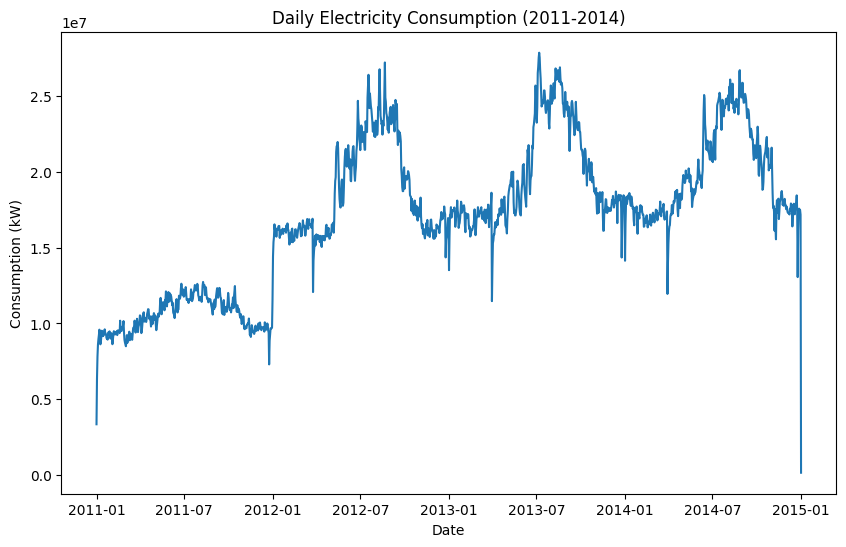

In [ ]:
# Resample the data to daily consumption
daily_consumption = df.resample('D').sum()

# Plot daily consumption
plt.figure(figsize=(10, 6))
plt.plot(daily_consumption.index, daily_consumption.sum(axis=1))
plt.title('Daily Electricity Consumption (2011-2014)')
plt.xlabel('Date')
plt.ylabel('Consumption (kW)')
plt.show()

Correlation Analysis:

Perform correlation analysis between different households' consumption.

Use heatmaps or pair plots to visualize relationships between households.

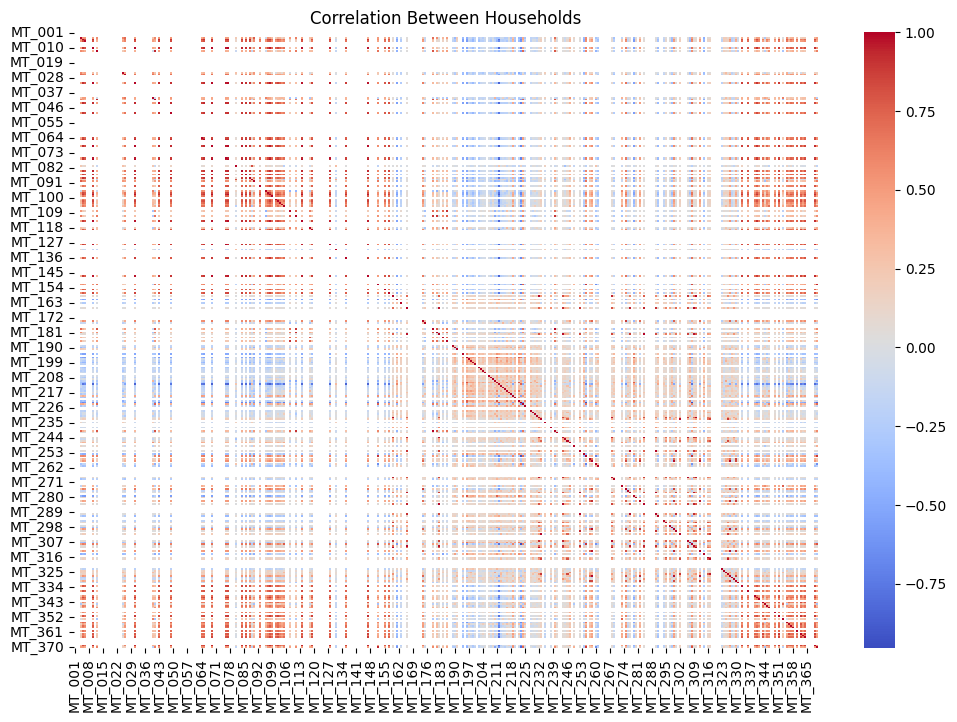

In [ ]:
# Correlation heatmap
corr_matrix = daily_consumption.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Between Households')
plt.show()

Time Series Forecasting

Train-Test Split:

Split the data into training and testing sets for forecasting.

Use the last 6 months of data as the test set and the remaining data as the training set.

In [ ]:
train_data = daily_consumption.iloc[:-180]
test_data = daily_consumption.iloc[-180:]

Build Forecasting Models:

Use models like ARIMA or Prophet to predict future electricity consumption.

Evaluate the model's performance using metrics like MAE (Mean Absolute Error) and RMSE (Root Mean Square Error).

Using ARIMA:

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


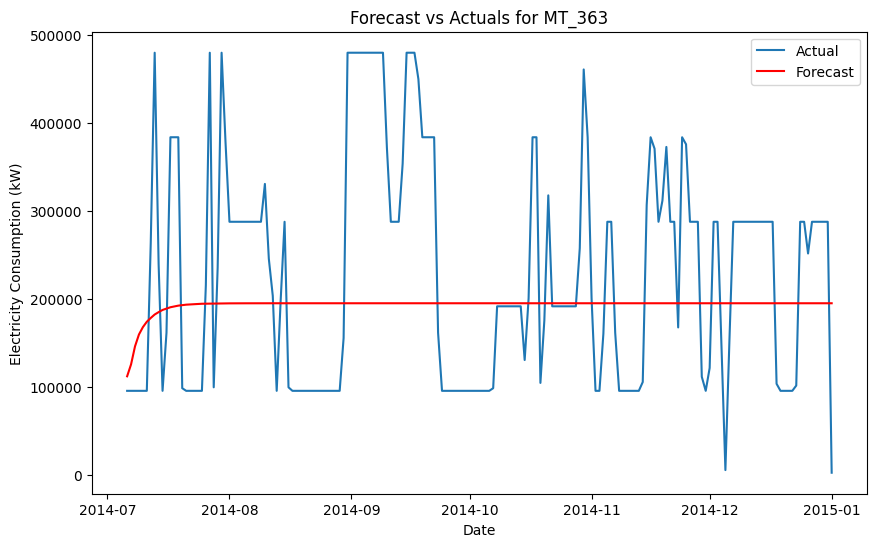

In [ ]:
# Forecast for a particular household
household = 'MT_363'  # You can change this to another household

# Fit ARIMA model (p, d, q need to be tuned based on the data)
model = ARIMA(train_data[household], order=(5, 1, 2))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test_data))

# Plot the forecast vs actuals
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data[household], label='Actual')
plt.plot(test_data.index, forecast, label='Forecast', color='red')
plt.title(f'Forecast vs Actuals for {household}')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (kW)')
plt.legend()
plt.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fwadwy0/kw1ymugf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fwadwy0/qohk8int.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74747', 'data', 'file=/tmp/tmp0fwadwy0/kw1ymugf.json', 'init=/tmp/tmp0fwadwy0/qohk8int.json', 'output', 'file=/tmp/tmp0fwadwy0/prophet_model40ssuapy/prophet_model-20240905034716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:47:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:47:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

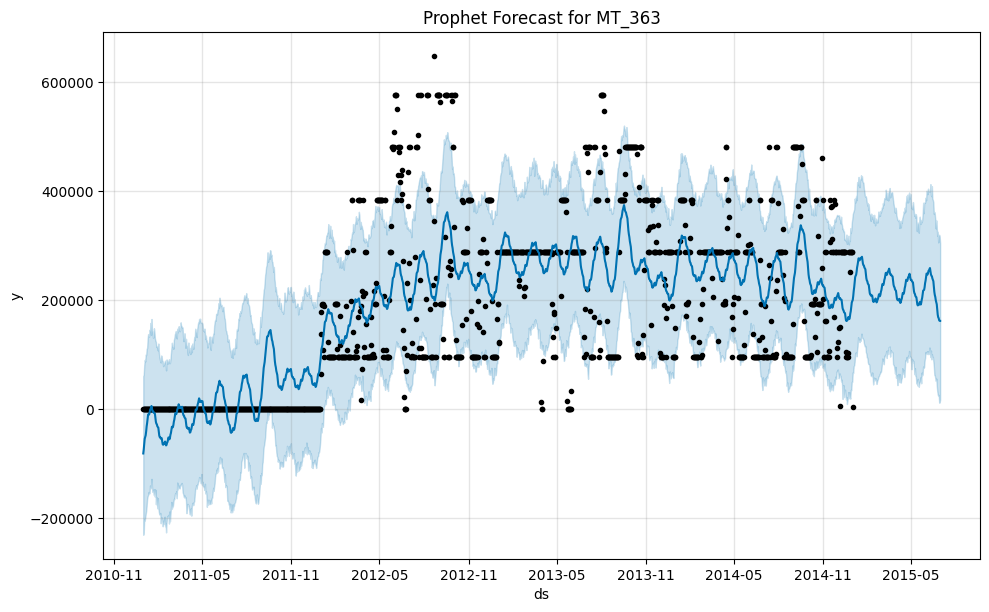

In [ ]:
# Prepare data for Prophet
prophet_data = daily_consumption.reset_index()[['Datetime', household]]
prophet_data.columns = ['ds', 'y']

# Fit Prophet model
m = Prophet()
m.fit(prophet_data)

# Create future dataframe and forecast
future = m.make_future_dataframe(periods=180)
forecast = m.predict(future)

# Plot forecast
m.plot(forecast)
plt.title(f'Prophet Forecast for {household}')
plt.show()

Anomaly Detection

Z-Score Method:

Detect anomalies in electricity consumption using Z-scores. Identify days where the consumption deviates significantly from the norm.

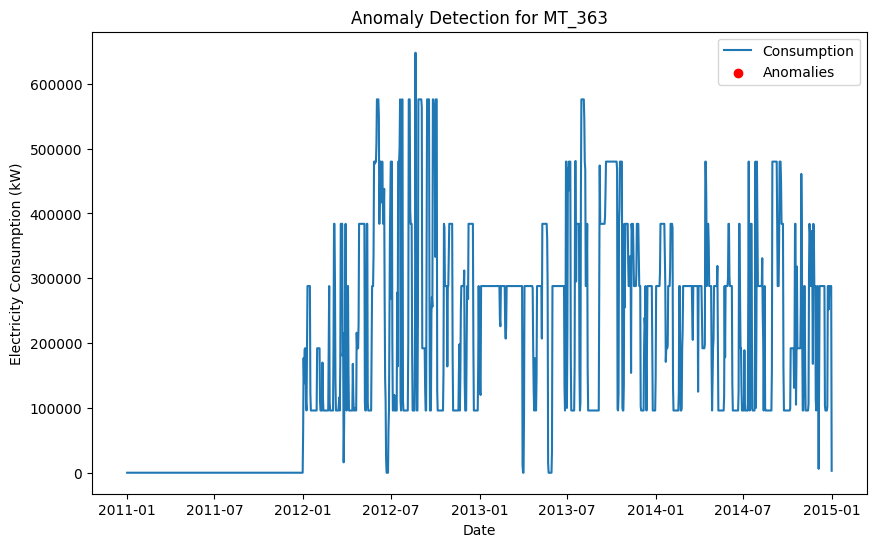

In [ ]:
# Calculate Z-scores for a particular household
z_scores = (daily_consumption[household] - daily_consumption[household].mean()) / daily_consumption[household].std()

# Mark anomalies where the Z-score exceeds a threshold (e.g., 3)
anomalies = daily_consumption[household][np.abs(z_scores) > 3]

# Plot anomalies
plt.figure(figsize=(10, 6))
plt.plot(daily_consumption[household], label='Consumption')
plt.scatter(anomalies.index, anomalies, color='red', label='Anomalies')
plt.title(f'Anomaly Detection for {household}')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (kW)')
plt.legend()
plt.show()